# 2D Power Spectrum Analysis — Background Pattern Detection

Analyze periodic background patterns (horizontal/vertical stripes, diagonal features,
elliptical radial structures) in REMIR sky-subtracted frames using FFT.

**Workflow:**
1. Load FITS image
2. Compute 2D FFT power spectrum
3. Analyze directional slices to find stripe angles & periods
4. Detect peaks via autocorrelation
5. Build multi-directional notch filter
6. Apply correction and compare
7. Save power spectrum matrix for sharing

In [1]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.signal import find_peaks
from scipy.ndimage import median_filter, gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

## 1. Load and inspect the image

Shape: (512, 512)
Filter: J
EXPTIME: 30.0s

Bad pixels (NaN/Inf): 9865 (3.8%)
Clipped stats (valid px) — mean: -0.03, median: 0.00, std: 68.49
Replaced 9865 bad pixels with median (0.00)


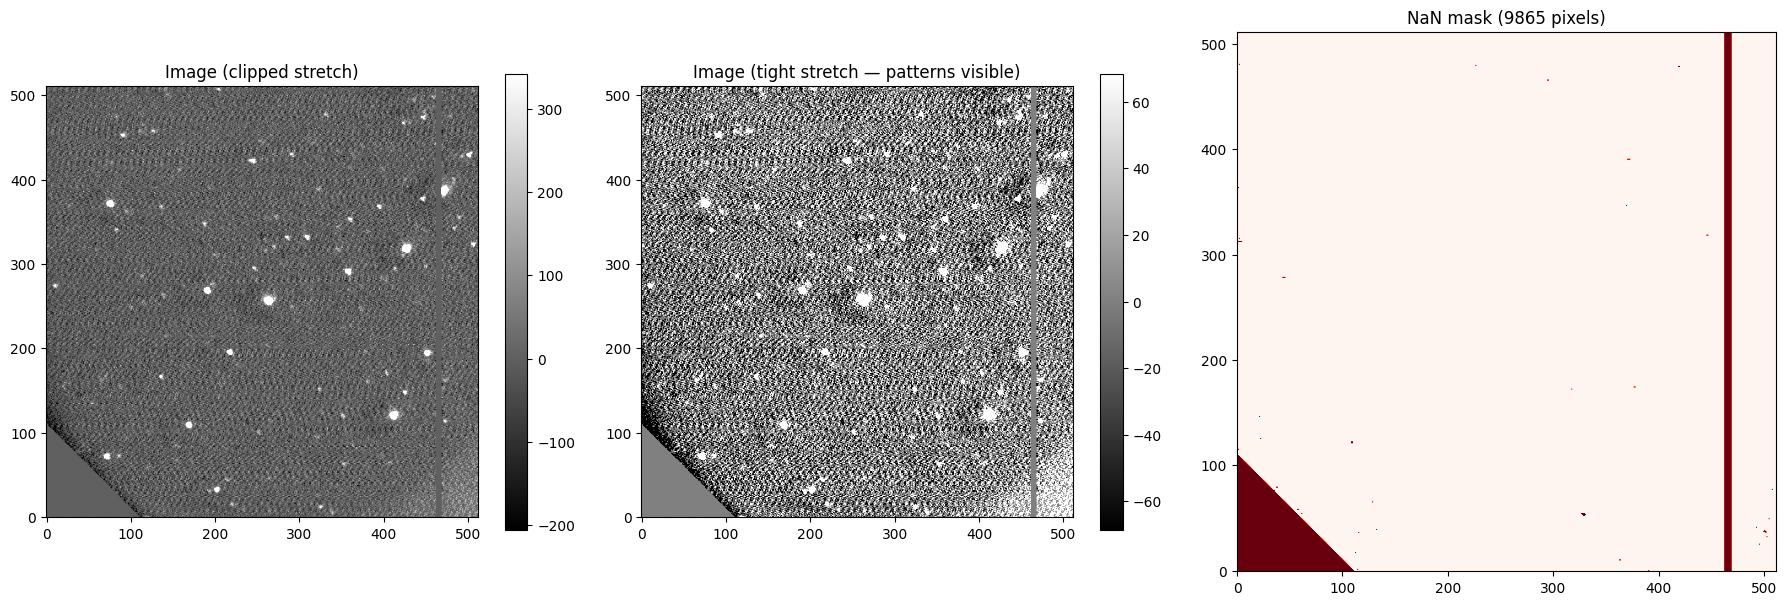

In [2]:
FITS_PATH = "/Users/matteoferro/Desktop/mmm/reduced/1A0538_66_1_30_J_1_skysub_aligned_astro.fits"

with fits.open(FITS_PATH) as hdul:
    data_raw = hdul[0].data.astype(np.float64)
    header = hdul[0].header

print(f"Shape: {data_raw.shape}")
print(f"Filter: {header.get('FILTER', 'N/A')}")
print(f"EXPTIME: {header.get('EXPTIME', 'N/A')}s")

# --- Handle NaN/Inf pixels (from alignment masking) ---
nan_mask = ~np.isfinite(data_raw)
n_bad = np.sum(nan_mask)
print(f"\nBad pixels (NaN/Inf): {n_bad} ({n_bad/data_raw.size*100:.1f}%)")

# Compute stats on valid pixels only
mean, median, std = sigma_clipped_stats(data_raw, sigma=3.0, mask=nan_mask)
print(f"Clipped stats (valid px) — mean: {mean:.2f}, median: {median:.2f}, std: {std:.2f}")

# Replace NaN/Inf with median so FFT works cleanly
data = data_raw.copy()
data[nan_mask] = median
print(f"Replaced {n_bad} bad pixels with median ({median:.2f})")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

vmin, vmax = median - 3*std, median + 5*std
im0 = axes[0].imshow(data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Image (clipped stretch)')
plt.colorbar(im0, ax=axes[0], shrink=0.8)

# Aggressive stretch to highlight faint patterns
vmin2, vmax2 = median - 1*std, median + 1*std
im1 = axes[1].imshow(data, origin='lower', cmap='gray', vmin=vmin2, vmax=vmax2)
axes[1].set_title('Image (tight stretch — patterns visible)')
plt.colorbar(im1, ax=axes[1], shrink=0.8)

# Show NaN mask
axes[2].imshow(nan_mask.astype(float), origin='lower', cmap='Reds', vmin=0, vmax=1)
axes[2].set_title(f'NaN mask ({n_bad} pixels)')

plt.tight_layout()
plt.show()

## 2. Compute 2D FFT Power Spectrum

Spectrum shape: (512, 512)
Center: (256, 256)
Power range: 1.47e+03 — 4.62e+11
Any NaN in power spectrum: False


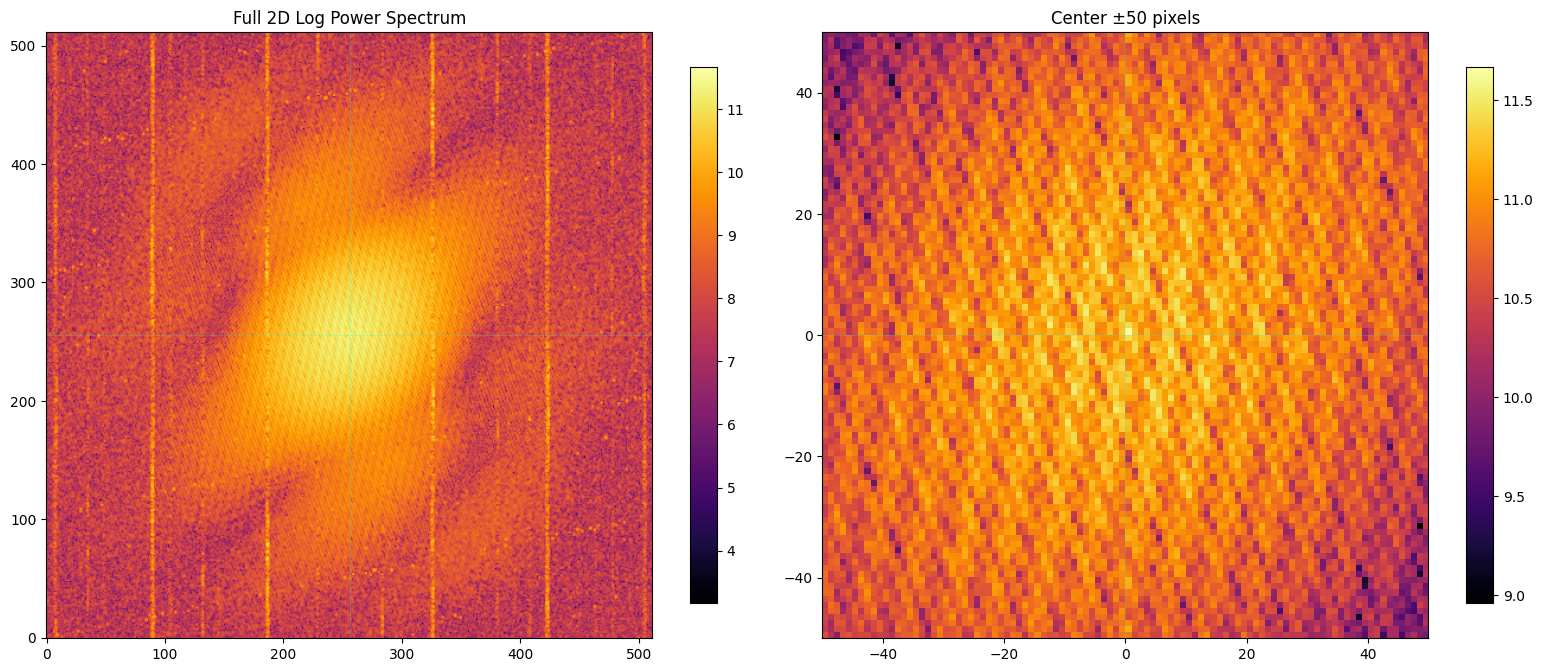

In [3]:
# Apply Hann window to reduce edge effects
ny, nx = data.shape
win_y = np.hanning(ny)
win_x = np.hanning(nx)
window = np.outer(win_y, win_x)

# Zero out the window where NaN mask is set (suppress those pixels)
window[nan_mask] = 0.0

# Subtract median before FFT (data already has NaNs replaced with median)
data_centered = (data - median) * window

# Sanity check
assert np.all(np.isfinite(data_centered)), "Still have non-finite values!"

# 2D FFT
F = fft2(data_centered)
F_shifted = fftshift(F)
power_spectrum = np.abs(F_shifted)**2

# Log power spectrum for display
log_power = np.log10(power_spectrum + 1)

cy, cx = ny // 2, nx // 2
print(f"Spectrum shape: {power_spectrum.shape}")
print(f"Center: ({cy}, {cx})")
print(f"Power range: {power_spectrum.min():.2e} — {power_spectrum.max():.2e}")
print(f"Any NaN in power spectrum: {np.any(np.isnan(power_spectrum))}")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Full power spectrum
im0 = axes[0].imshow(log_power, origin='lower', cmap='inferno')
axes[0].set_title('Full 2D Log Power Spectrum')
axes[0].axhline(cy, color='cyan', alpha=0.3, lw=0.5)
axes[0].axvline(cx, color='cyan', alpha=0.3, lw=0.5)
plt.colorbar(im0, ax=axes[0], shrink=0.8)

# Zoomed center (±50 pixels)
zoom = 50
crop = log_power[cy-zoom:cy+zoom, cx-zoom:cx+zoom]
im1 = axes[1].imshow(crop, origin='lower', cmap='inferno',
                      extent=[-zoom, zoom, -zoom, zoom])
axes[1].set_title(f'Center ±{zoom} pixels')
axes[1].axhline(0, color='cyan', alpha=0.3, lw=0.5)
axes[1].axvline(0, color='cyan', alpha=0.3, lw=0.5)
plt.colorbar(im1, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()

## 3. Directional Slices — Find Stripe Angles & Periods
Extract radial slices through the power spectrum at multiple angles to identify
which directions have excess power (= stripes in that direction).

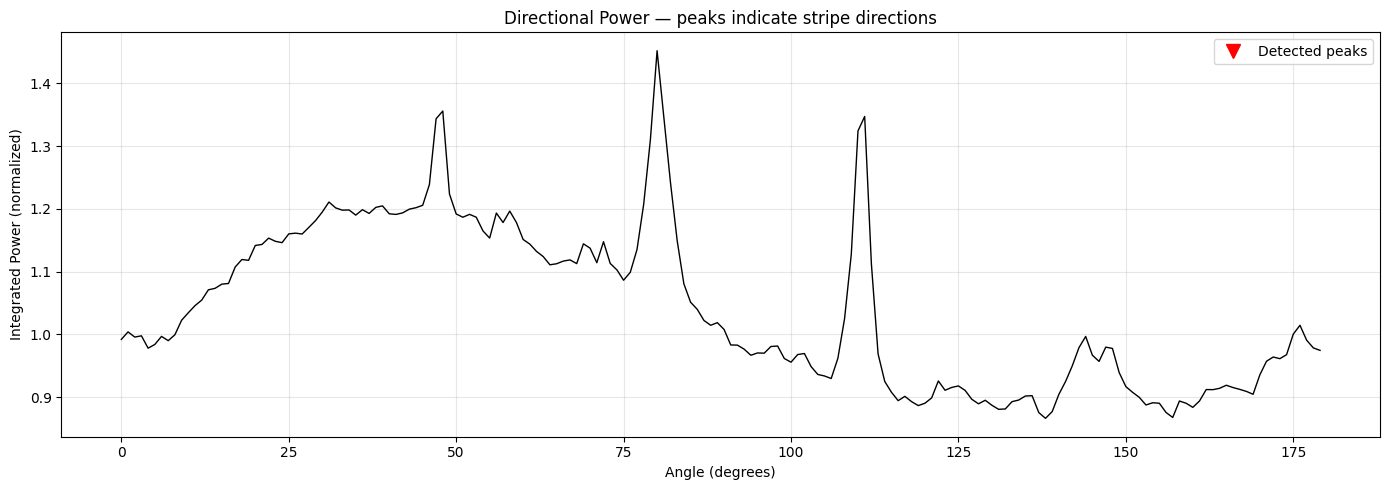


Detected peak angles (stripe directions in frequency domain):


In [4]:
def extract_radial_slice(power, angle_deg, center=None, length=None):
    """
    Extract a 1D radial slice through the 2D power spectrum at angle_deg.
    angle_deg=0 is horizontal (right), 90 is vertical (up).
    Returns (radii, values) for the positive half.
    """
    ny, nx = power.shape
    if center is None:
        center = (ny // 2, nx // 2)
    if length is None:
        length = min(ny, nx) // 2 - 1

    cy, cx = center
    theta = np.radians(angle_deg)
    radii = np.arange(1, length)  # skip DC

    values = []
    for r in radii:
        x = cx + r * np.cos(theta)
        y = cy + r * np.sin(theta)
        # Bilinear interpolation
        x0, y0 = int(np.floor(x)), int(np.floor(y))
        x1, y1 = x0 + 1, y0 + 1
        if 0 <= x0 < nx-1 and 0 <= y0 < ny-1:
            fx, fy = x - x0, y - y0
            val = (power[y0, x0] * (1-fx)*(1-fy) +
                   power[y0, x1] * fx*(1-fy) +
                   power[y1, x0] * (1-fx)*fy +
                   power[y1, x1] * fx*fy)
            values.append(val)
        else:
            values.append(0)

    return radii, np.array(values)


# Scan 180 degrees in 1-degree steps
angles = np.arange(0, 180, 1)
integrated_power = []

for a in angles:
    r, vals = extract_radial_slice(power_spectrum, a)
    integrated_power.append(np.sum(vals[5:]))  # skip first 5 (low-freq)

integrated_power = np.array(integrated_power)

# Find peak angles
ip_norm = integrated_power / np.median(integrated_power)
peaks, props = find_peaks(ip_norm, height=1.5, distance=5, prominence=0.3)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(angles, ip_norm, 'k-', lw=1)
ax.plot(angles[peaks], ip_norm[peaks], 'rv', ms=10, label='Detected peaks')
for p in peaks:
    ax.annotate(f'{angles[p]}°', (angles[p], ip_norm[p]),
                textcoords='offset points', xytext=(5, 10), color='red', fontsize=10)
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Integrated Power (normalized)')
ax.set_title('Directional Power — peaks indicate stripe directions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDetected peak angles (stripe directions in frequency domain):")
for p in peaks:
    real_angle = (angles[p] + 90) % 180  # stripes are perpendicular to frequency direction
    print(f"  Freq direction: {angles[p]}° → Stripe direction in image: {real_angle}° (power: {ip_norm[p]:.2f}x median)")

## 4. Detailed Radial Profiles Along Detected Directions
For each detected peak angle, plot the radial power profile to find the characteristic spatial frequencies (= stripe periods in pixels).

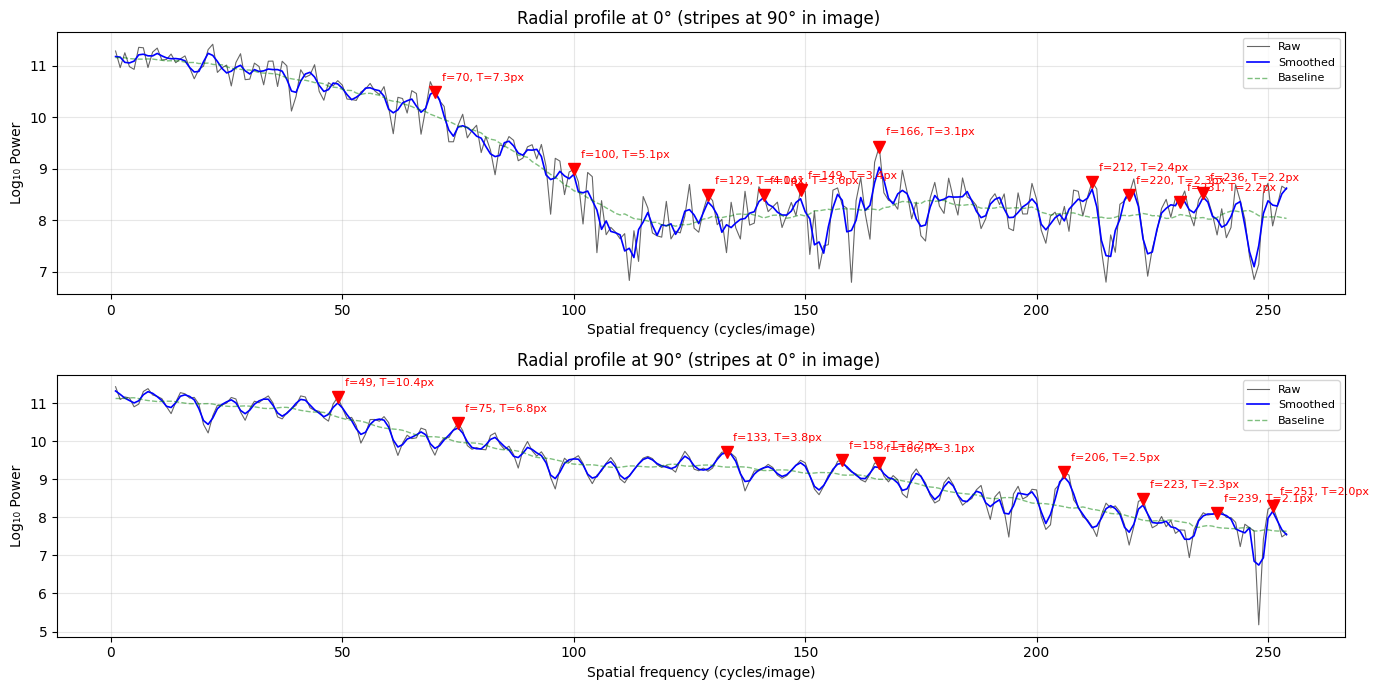


Summary of detected periodic features:

Freq direction 0° (stripes at 90°):
  freq= 70 cycles/image → period=7.3 pixels
  freq=100 cycles/image → period=5.1 pixels
  freq=129 cycles/image → period=4.0 pixels
  freq=141 cycles/image → period=3.6 pixels
  freq=149 cycles/image → period=3.4 pixels
  freq=166 cycles/image → period=3.1 pixels
  freq=212 cycles/image → period=2.4 pixels
  freq=220 cycles/image → period=2.3 pixels
  freq=231 cycles/image → period=2.2 pixels
  freq=236 cycles/image → period=2.2 pixels

Freq direction 90° (stripes at 0°):
  freq= 49 cycles/image → period=10.4 pixels
  freq= 75 cycles/image → period=6.8 pixels
  freq=133 cycles/image → period=3.8 pixels
  freq=158 cycles/image → period=3.2 pixels
  freq=166 cycles/image → period=3.1 pixels
  freq=206 cycles/image → period=2.5 pixels
  freq=223 cycles/image → period=2.3 pixels
  freq=239 cycles/image → period=2.1 pixels
  freq=251 cycles/image → period=2.0 pixels


In [5]:
# Also include horizontal (0°) and vertical (90°) for reference
check_angles = sorted(set(list(angles[peaks]) + [0, 90]))

fig, axes = plt.subplots(len(check_angles), 1, figsize=(14, 3.5*len(check_angles)))
if len(check_angles) == 1:
    axes = [axes]

all_peaks_info = {}

for ax, a in zip(axes, check_angles):
    r, vals = extract_radial_slice(power_spectrum, a)
    log_vals = np.log10(vals + 1)

    # Smooth for peak finding
    from scipy.ndimage import uniform_filter1d
    smoothed = uniform_filter1d(log_vals, size=3)
    baseline = uniform_filter1d(log_vals, size=30)
    deviation = smoothed - baseline

    freq_peaks, fp = find_peaks(deviation, height=0.3, distance=3, prominence=0.2)

    ax.plot(r, log_vals, 'k-', lw=0.8, alpha=0.6, label='Raw')
    ax.plot(r, smoothed, 'b-', lw=1.2, label='Smoothed')
    ax.plot(r, baseline, 'g--', lw=1, alpha=0.5, label='Baseline')

    periods = []
    if len(freq_peaks) > 0:
        ax.plot(r[freq_peaks], log_vals[freq_peaks], 'rv', ms=8)
        for fp_idx in freq_peaks:
            freq = r[fp_idx]
            period = data.shape[0] / freq  # spatial period in pixels
            periods.append((freq, period))
            ax.annotate(f'f={freq}, T={period:.1f}px',
                       (r[fp_idx], log_vals[fp_idx]),
                       textcoords='offset points', xytext=(5, 8),
                       color='red', fontsize=8)

    real_angle = (a + 90) % 180
    label = '← detected' if a in angles[peaks] else ''
    ax.set_title(f'Radial profile at {a}° (stripes at {real_angle}° in image) {label}',
                fontweight='bold' if a in angles[peaks] else 'normal')
    ax.set_xlabel('Spatial frequency (cycles/image)')
    ax.set_ylabel('Log₁₀ Power')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

    if periods:
        all_peaks_info[a] = periods

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Summary of detected periodic features:")
print("="*60)
for angle, peaks_list in all_peaks_info.items():
    real_angle = (angle + 90) % 180
    print(f"\nFreq direction {angle}° (stripes at {real_angle}°):")
    for freq, period in peaks_list:
        print(f"  freq={freq:3d} cycles/image → period={period:.1f} pixels")

## 5. Radial & Azimuthal Profiles — Detect Elliptical Features

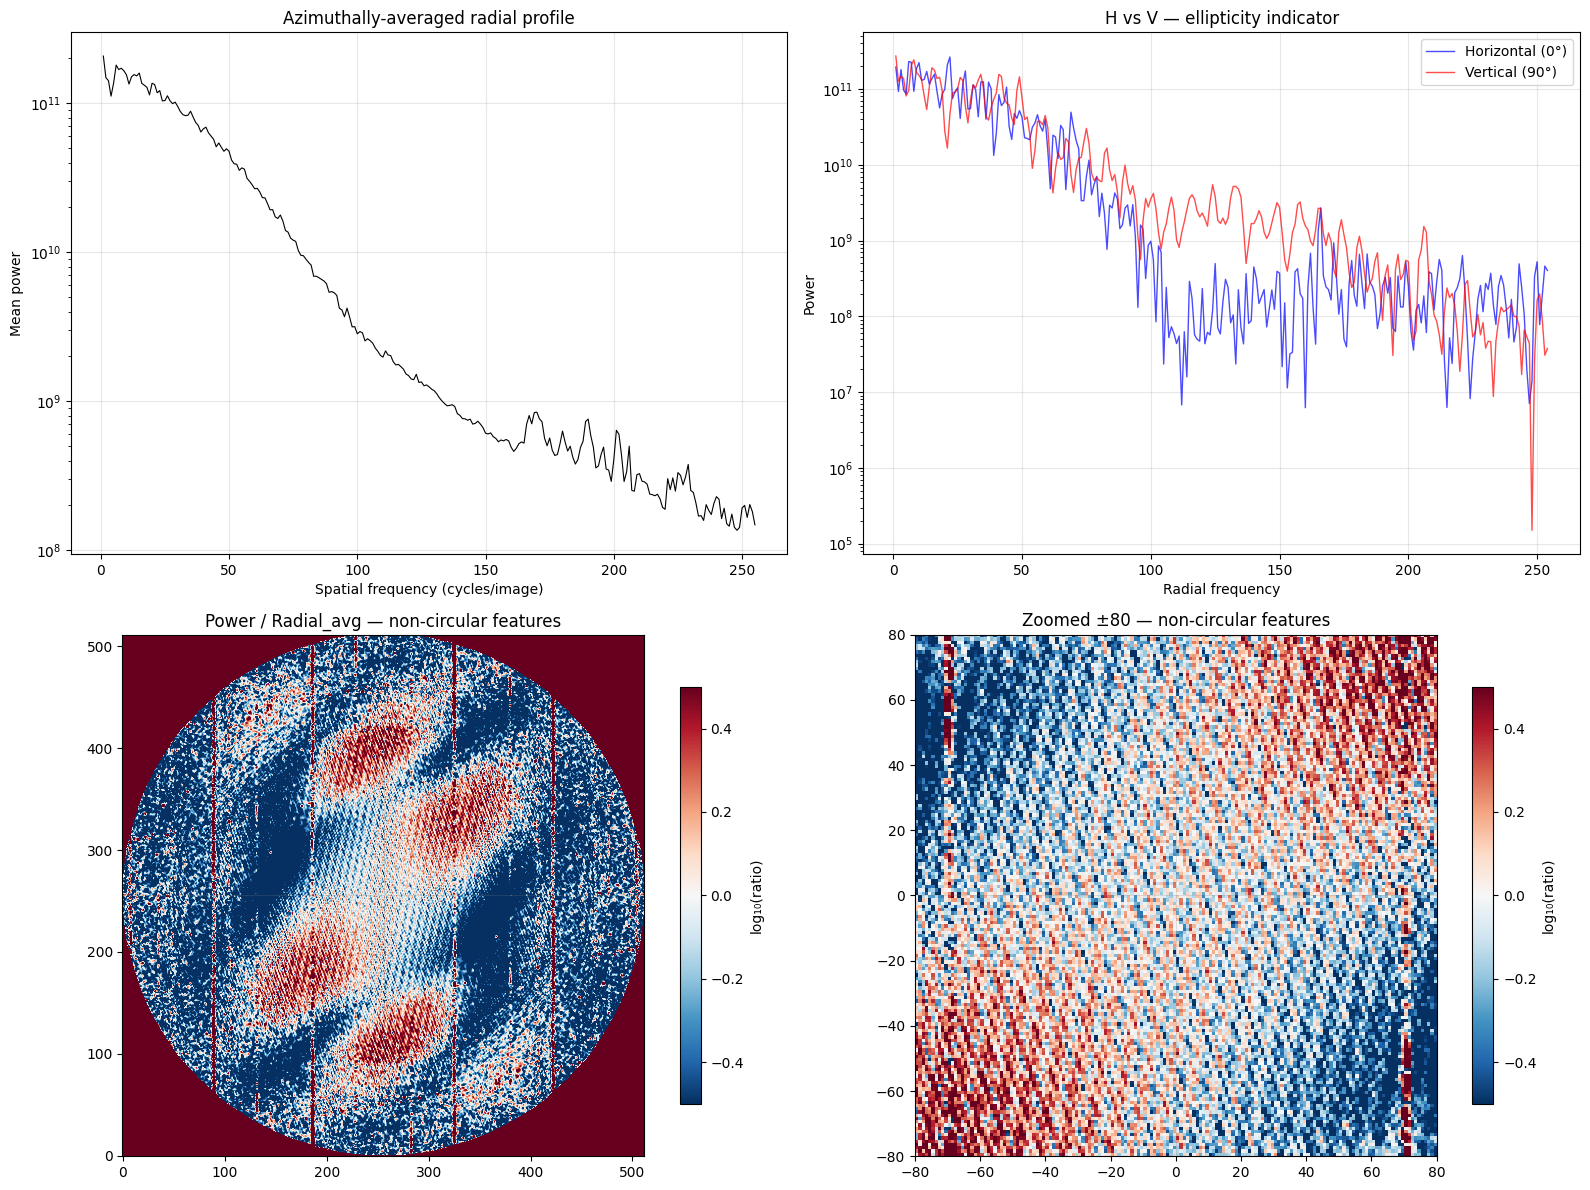


Ellipticity analysis (ratio of power at 0° vs 90° at fixed radii):
  r= 10: P_horiz=1.56e+11, P_vert=1.50e+11, ratio=1.04
  r= 20: P_horiz=1.36e+11, P_vert=1.18e+11, ratio=1.16
  r= 30: P_horiz=9.68e+10, P_vert=9.60e+10, ratio=1.01
  r= 50: P_horiz=3.81e+10, P_vert=5.41e+10, ratio=0.70
  r= 80: P_horiz=5.56e+09, P_vert=8.32e+09, ratio=0.67
  r=100: P_horiz=5.66e+08, P_vert=2.81e+09, ratio=0.20


In [6]:
# Azimuthally-averaged radial profile
Y, X = np.ogrid[:ny, :nx]
R = np.sqrt((X - cx)**2 + (Y - cy)**2).astype(int)
max_r = min(ny, nx) // 2

radial_profile = np.zeros(max_r)
radial_count = np.zeros(max_r)
for r_val in range(max_r):
    mask = R == r_val
    if np.any(mask):
        radial_profile[r_val] = np.mean(power_spectrum[mask])
        radial_count[r_val] = np.sum(mask)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Radial profile
ax = axes[0, 0]
ax.semilogy(np.arange(1, max_r), radial_profile[1:], 'k-', lw=0.8)
ax.set_xlabel('Spatial frequency (cycles/image)')
ax.set_ylabel('Mean power')
ax.set_title('Azimuthally-averaged radial profile')
ax.grid(True, alpha=0.3)

# Ellipticity test: compare horizontal vs vertical radial cuts
ax = axes[0, 1]
r_h, v_h = extract_radial_slice(power_spectrum, 0)   # horizontal
r_v, v_v = extract_radial_slice(power_spectrum, 90)  # vertical
ax.semilogy(r_h, v_h, 'b-', lw=1, alpha=0.7, label='Horizontal (0°)')
ax.semilogy(r_v, v_v, 'r-', lw=1, alpha=0.7, label='Vertical (90°)')
ax.set_xlabel('Radial frequency')
ax.set_ylabel('Power')
ax.set_title('H vs V — ellipticity indicator')
ax.legend()
ax.grid(True, alpha=0.3)

# Power spectrum divided by radial average → highlight non-radial (elliptical) features
radial_model = np.zeros_like(power_spectrum)
for r_val in range(max_r):
    mask = R == r_val
    if radial_profile[r_val] > 0:
        radial_model[mask] = radial_profile[r_val]
    else:
        radial_model[mask] = 1

ratio = power_spectrum / (radial_model + 1e-10)
log_ratio = np.log10(ratio + 0.01)

ax = axes[1, 0]
im = ax.imshow(log_ratio, origin='lower', cmap='RdBu_r',
               vmin=-0.5, vmax=0.5)
ax.set_title('Power / Radial_avg — non-circular features')
ax.axhline(cy, color='gray', alpha=0.3, lw=0.5)
ax.axvline(cx, color='gray', alpha=0.3, lw=0.5)
plt.colorbar(im, ax=ax, shrink=0.8, label='log₁₀(ratio)')

# Zoomed version
ax = axes[1, 1]
zoom = 80
crop_ratio = log_ratio[cy-zoom:cy+zoom, cx-zoom:cx+zoom]
im = ax.imshow(crop_ratio, origin='lower', cmap='RdBu_r',
               vmin=-0.5, vmax=0.5,
               extent=[-zoom, zoom, -zoom, zoom])
ax.set_title(f'Zoomed ±{zoom} — non-circular features')
ax.axhline(0, color='gray', alpha=0.3, lw=0.5)
ax.axvline(0, color='gray', alpha=0.3, lw=0.5)
plt.colorbar(im, ax=ax, shrink=0.8, label='log₁₀(ratio)')

plt.tight_layout()
plt.show()

# Quantify ellipticity by fitting power at fixed radii vs angle
print("\nEllipticity analysis (ratio of power at 0° vs 90° at fixed radii):")
for test_r in [10, 20, 30, 50, 80, 100]:
    ring_mask = (R >= test_r - 2) & (R <= test_r + 2)
    # Split into quadrants
    h_mask = ring_mask & (np.abs(Y - cy) < 3)
    v_mask = ring_mask & (np.abs(X - cx) < 3)
    p_h = np.mean(power_spectrum[h_mask]) if np.any(h_mask) else 0
    p_v = np.mean(power_spectrum[v_mask]) if np.any(v_mask) else 0
    ratio_hv = p_h / p_v if p_v > 0 else float('inf')
    print(f"  r={test_r:3d}: P_horiz={p_h:.2e}, P_vert={p_v:.2e}, ratio={ratio_hv:.2f}")

## 6. 2D Autocorrelation — Period Detection

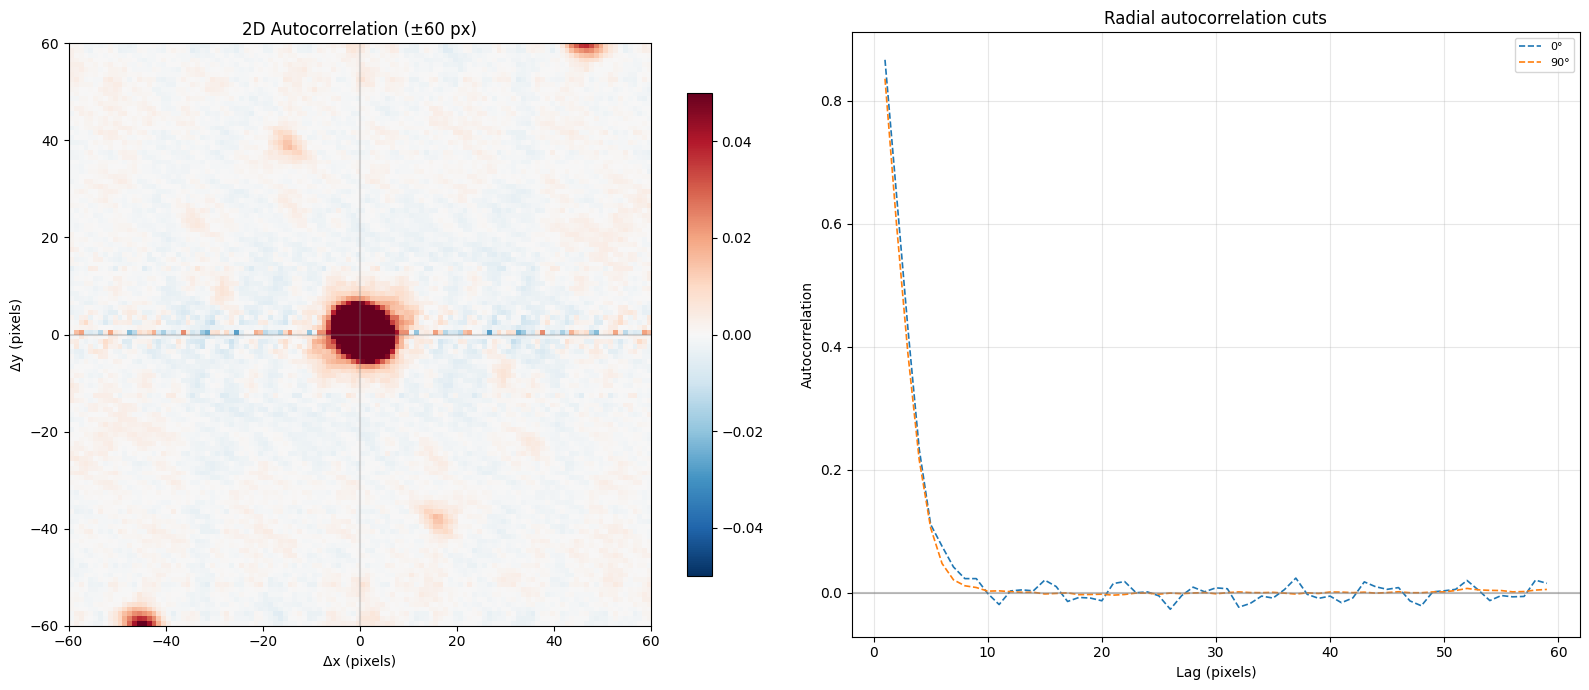

In [7]:
# 2D autocorrelation = inverse FFT of power spectrum
autocorr = np.real(ifft2(ifftshift(power_spectrum)))
autocorr = fftshift(autocorr)  # center it
autocorr /= autocorr.max()     # normalize to [0, 1]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

zoom_ac = 60
ac_crop = autocorr[cy-zoom_ac:cy+zoom_ac, cx-zoom_ac:cx+zoom_ac]

im0 = axes[0].imshow(ac_crop, origin='lower', cmap='RdBu_r',
                      vmin=-0.05, vmax=0.05,
                      extent=[-zoom_ac, zoom_ac, -zoom_ac, zoom_ac])
axes[0].set_title(f'2D Autocorrelation (±{zoom_ac} px)')
axes[0].set_xlabel('Δx (pixels)')
axes[0].set_ylabel('Δy (pixels)')
axes[0].axhline(0, color='gray', alpha=0.3)
axes[0].axvline(0, color='gray', alpha=0.3)
plt.colorbar(im0, ax=axes[0], shrink=0.8)

# Autocorrelation cuts along detected directions
ax = axes[1]
for a in check_angles:
    r, vals = extract_radial_slice(autocorr, a, length=zoom_ac)
    label = f"{a}°" + (" ★" if a in angles[peaks] else "")
    style = '-' if a in angles[peaks] else '--'
    ax.plot(r, vals, style, lw=1.2, label=label)

ax.set_xlabel('Lag (pixels)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Radial autocorrelation cuts')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Build & Apply Multi-Directional Notch Filter
Based on detected stripe directions and frequencies, build a composite notch filter.

Using detected directions: []
(You can manually add/edit angles in the list below)


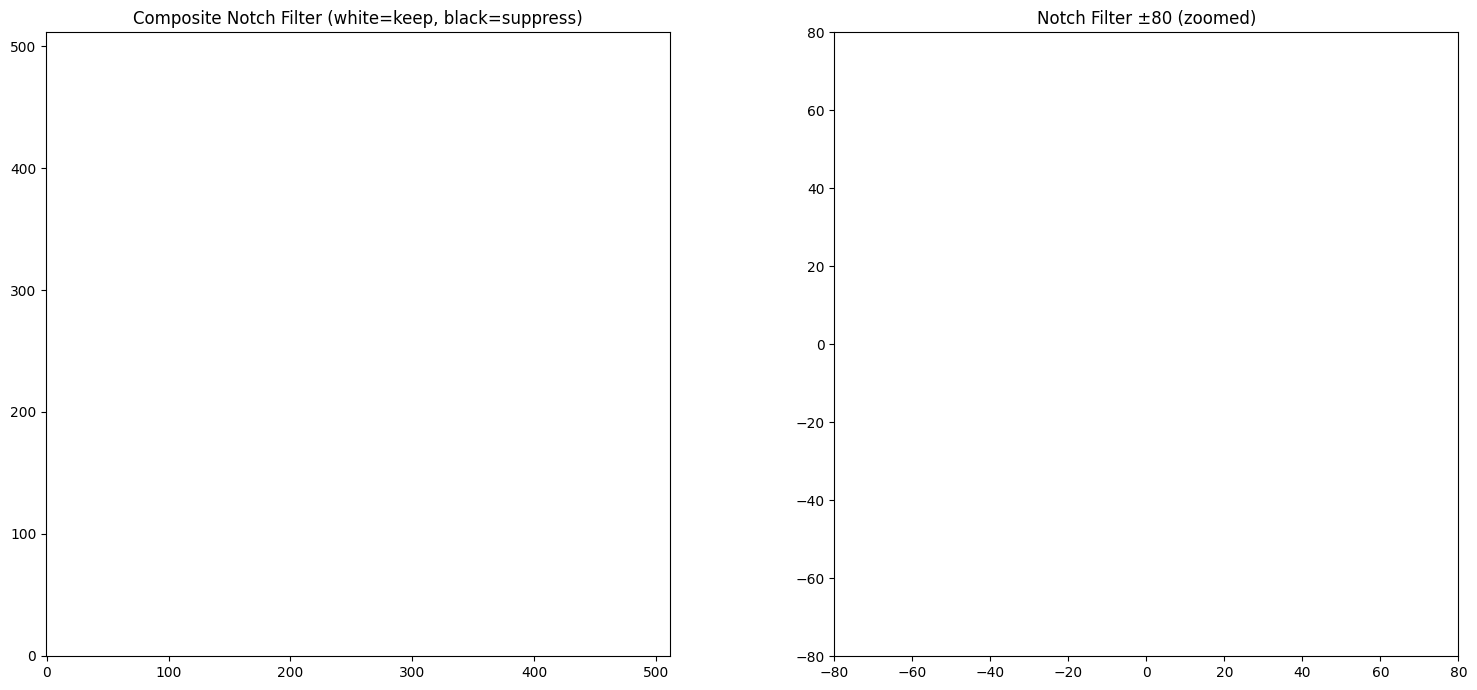

In [8]:
def build_directional_notch(shape, center, angle_deg, angular_width_deg=5.0,
                            freq_min=3, freq_max=None):
    """
    Build a notch mask that suppresses power along a specific direction.
    Returns a 2D array: 1 = keep, 0 = suppress.
    """
    ny, nx = shape
    cy, cx = center
    if freq_max is None:
        freq_max = min(ny, nx) // 2

    Y, X = np.mgrid[:ny, :nx]
    dY = Y - cy
    dX = X - cx
    R = np.sqrt(dX**2 + dY**2)
    Theta = np.degrees(np.arctan2(dY, dX)) % 360  # 0..360

    angle1 = angle_deg % 360
    angle2 = (angle_deg + 180) % 360  # opposite direction

    hw = angular_width_deg / 2

    def angle_near(th, target, half_width):
        diff = np.abs(((th - target + 180) % 360) - 180)
        return diff < half_width

    dir_mask = angle_near(Theta, angle1, hw) | angle_near(Theta, angle2, hw)
    freq_mask = (R >= freq_min) & (R <= freq_max)

    notch = np.ones((ny, nx), dtype=np.float64)
    notch[dir_mask & freq_mask] = 0.0

    # Smooth edges
    notch = gaussian_filter(notch, sigma=1.0)
    return notch


def build_composite_notch(shape, center, directions, angular_width=5.0,
                          freq_min=3, freq_max=None):
    """
    Build composite notch from multiple directions.
    directions: list of angles in degrees.
    """
    composite = np.ones(shape, dtype=np.float64)
    for angle in directions:
        notch = build_directional_notch(shape, center, angle, angular_width,
                                        freq_min, freq_max)
        composite *= notch
    return composite


# Auto-detect: use peak angles from cell 3
detected_directions = list(angles[peaks])
print(f"Using detected directions: {detected_directions}")
print("(You can manually add/edit angles in the list below)")

# ============================================================
# MANUAL OVERRIDE — edit these if auto-detection isn't perfect
# ============================================================
STRIPE_DIRECTIONS = detected_directions  # e.g. [0, 30, 90, 150]
ANGULAR_WIDTH = 5.0    # degrees (wider = more aggressive filtering)
FREQ_MIN = 3           # skip DC region
FREQ_MAX = None        # None = use all frequencies
# ============================================================

notch_filter = build_composite_notch(
    power_spectrum.shape, (cy, cx),
    STRIPE_DIRECTIONS, ANGULAR_WIDTH, FREQ_MIN, FREQ_MAX
)

# Show the filter
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].imshow(notch_filter, origin='lower', cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Composite Notch Filter (white=keep, black=suppress)')

zoom_n = 80
axes[1].imshow(notch_filter[cy-zoom_n:cy+zoom_n, cx-zoom_n:cx+zoom_n],
               origin='lower', cmap='gray', vmin=0, vmax=1,
               extent=[-zoom_n, zoom_n, -zoom_n, zoom_n])
axes[1].set_title(f'Notch Filter ±{zoom_n} (zoomed)')

plt.tight_layout()
plt.show()

## 8. Apply Notch Filter & Compare

Removed pattern stats: mean=0.0000, median=0.0000, std=0.0000

Original  — mean: -0.05, std: 66.68
Corrected — mean: -0.05, std: 66.68
Noise reduction: -0.0%


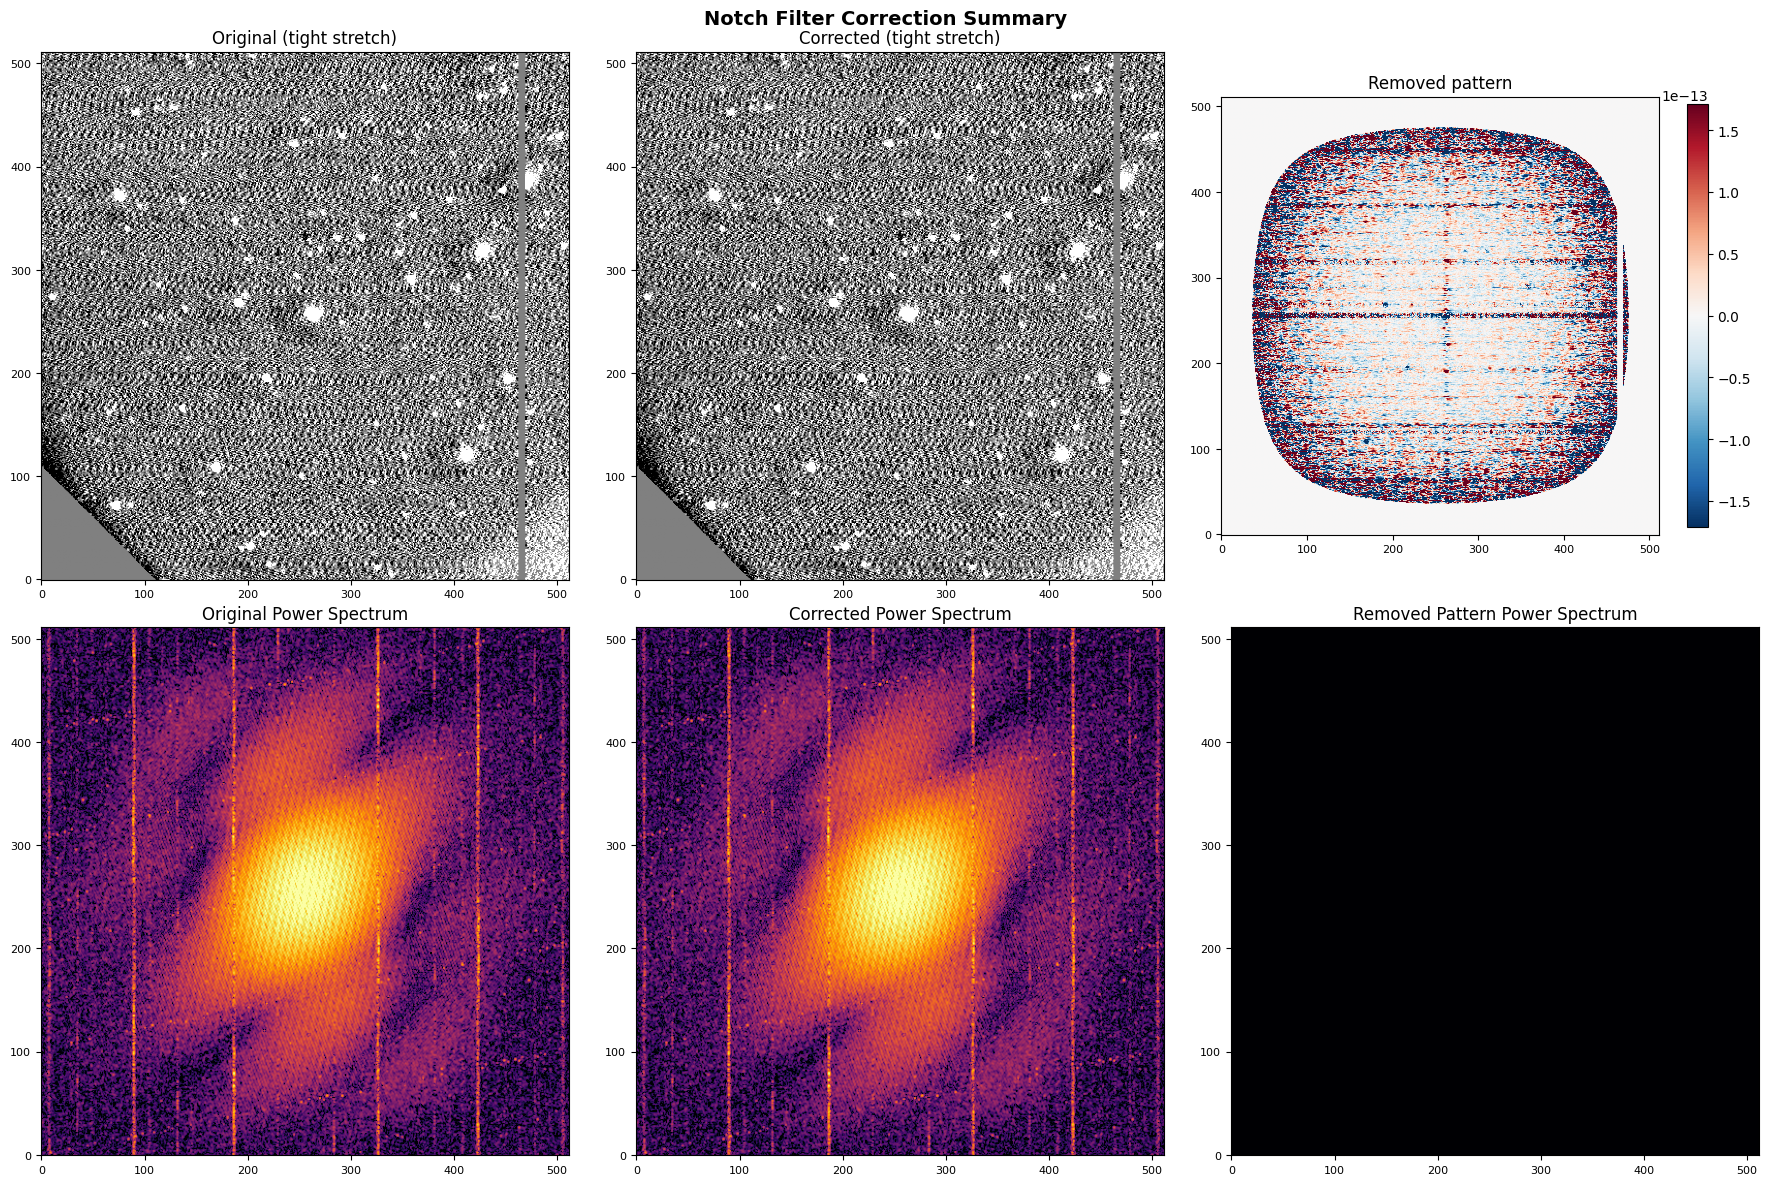

In [9]:
# Apply notch filter in frequency domain
F_filtered = F_shifted * notch_filter

# Inverse FFT (undo windowing approximately)
corrected_windowed = np.real(ifft2(ifftshift(F_filtered)))

# Un-window: divide by window, but avoid division by zero
safe_window = np.where(window > 0.05, window, 1.0)
corrected = corrected_windowed / safe_window + median

# Mask edges where window was near zero
edge_mask = window < 0.05
corrected[edge_mask] = data[edge_mask]

# Compute what was removed
removed = data - corrected

# Stats
mean_r, med_r, std_r = sigma_clipped_stats(removed, sigma=3.0)
print(f"Removed pattern stats: mean={mean_r:.4f}, median={med_r:.4f}, std={std_r:.4f}")

# Compare
mean_o, med_o, std_o = sigma_clipped_stats(data, sigma=3.0)
mean_c, med_c, std_c = sigma_clipped_stats(corrected, sigma=3.0)
print(f"\nOriginal  — mean: {mean_o:.2f}, std: {std_o:.2f}")
print(f"Corrected — mean: {mean_c:.2f}, std: {std_c:.2f}")
print(f"Noise reduction: {(1 - std_c/std_o)*100:.1f}%")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

vmin, vmax = med_o - 3*std_o, med_o + 5*std_o
vmin_t, vmax_t = med_o - 1*std_o, med_o + 1*std_o  # tight stretch

# Row 1: full images
axes[0,0].imshow(data, origin='lower', cmap='gray', vmin=vmin_t, vmax=vmax_t)
axes[0,0].set_title('Original (tight stretch)')

axes[0,1].imshow(corrected, origin='lower', cmap='gray', vmin=vmin_t, vmax=vmax_t)
axes[0,1].set_title('Corrected (tight stretch)')

im_rem = axes[0,2].imshow(removed, origin='lower', cmap='RdBu_r',
                           vmin=-3*std_r, vmax=3*std_r)
axes[0,2].set_title('Removed pattern')
plt.colorbar(im_rem, ax=axes[0,2], shrink=0.8)

# Row 2: power spectra
F_corr = fft2((corrected - med_c) * window)
ps_corr = np.abs(fftshift(F_corr))**2
log_ps_corr = np.log10(ps_corr + 1)

ps_removed = np.abs(fftshift(fft2((removed - med_r) * window)))**2
log_ps_removed = np.log10(ps_removed + 1)

vmin_ps = np.percentile(log_power, 5)
vmax_ps = np.percentile(log_power, 99.5)

axes[1,0].imshow(log_power, origin='lower', cmap='inferno', vmin=vmin_ps, vmax=vmax_ps)
axes[1,0].set_title('Original Power Spectrum')

axes[1,1].imshow(log_ps_corr, origin='lower', cmap='inferno', vmin=vmin_ps, vmax=vmax_ps)
axes[1,1].set_title('Corrected Power Spectrum')

axes[1,2].imshow(log_ps_removed, origin='lower', cmap='inferno')
axes[1,2].set_title('Removed Pattern Power Spectrum')

for ax in axes.flat:
    ax.tick_params(labelsize=8)

plt.suptitle('Notch Filter Correction Summary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Alternative Methods for Comparison
Row/column median subtraction and spatial median filter.

In [ ]:
# Method A: Row + Column median subtraction (NaN-safe)
row_med = np.nanmedian(data_raw, axis=1, keepdims=True)
col_med = np.nanmedian(data_raw, axis=0, keepdims=True)
global_med = np.nanmedian(data_raw)
data_rowcol = data - np.nan_to_num(row_med, nan=0) - np.nan_to_num(col_med, nan=0) + global_med

# Method B: Spatial median filter (works on NaN-cleaned data)
FILTER_SIZE = 31  # must be odd
bg_model = median_filter(data, size=FILTER_SIZE)
data_medfilt = data - bg_model + global_med

# Compare all methods
methods = {
    'Original': data,
    'FFT Notch': corrected,
    'Row/Col Median': data_rowcol,
    f'Median Filter ({FILTER_SIZE}px)': data_medfilt,
}

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
for ax, (name, img) in zip(axes.flat, methods.items()):
    m, md, s = sigma_clipped_stats(img, sigma=3.0)
    v1, v2 = md - 1*s, md + 1*s
    ax.imshow(img, origin='lower', cmap='gray', vmin=v1, vmax=v2)
    ax.set_title(f'{name}  (σ={s:.2f})', fontsize=12)

plt.suptitle('Method Comparison (tight stretch)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Stats table
print(f"{'Method':<30s} {'Mean':>10s} {'Median':>10s} {'Std':>10s} {'Noise Red.':>12s}")
print("-" * 75)
for name, img in methods.items():
    m, md, s = sigma_clipped_stats(img, sigma=3.0)
    nr = (1 - s/std_o) * 100
    print(f"{name:<30s} {m:10.2f} {md:10.2f} {s:10.2f} {nr:11.1f}%")

## 10. Save Power Spectrum Matrix
Save the 2D power spectrum as a `.npy` file so it can be loaded and shared.

In [ ]:
# Save directory — same as the FITS input
save_dir = os.path.dirname(FITS_PATH)
base_name = os.path.splitext(os.path.basename(FITS_PATH))[0]

# Save power spectrum (float64, full resolution)
ps_path = os.path.join(save_dir, f"{base_name}_power_spectrum.npy")
np.save(ps_path, power_spectrum)
print(f"Saved power spectrum: {ps_path}")
print(f"  Shape: {power_spectrum.shape}, dtype: {power_spectrum.dtype}")
print(f"  Size: {os.path.getsize(ps_path) / 1e6:.1f} MB")

# Also save log power spectrum (smaller dynamic range, easier to inspect)
logps_path = os.path.join(save_dir, f"{base_name}_log_power_spectrum.npy")
np.save(logps_path, log_power.astype(np.float32))
print(f"\nSaved log power spectrum: {logps_path}")
print(f"  Size: {os.path.getsize(logps_path) / 1e6:.1f} MB")

# Save corrected FITS
corrected_path = os.path.join(save_dir, f"{base_name}_notch_corrected.fits")
hdu = fits.PrimaryHDU(corrected.astype(np.float32), header=header)
hdu.header['HISTORY'] = f'FFT notch filter applied: directions={STRIPE_DIRECTIONS}'
hdu.header['HISTORY'] = f'Angular width={ANGULAR_WIDTH} deg, freq_min={FREQ_MIN}'
hdu.writeto(corrected_path, overwrite=True)
print(f"\nSaved corrected FITS: {corrected_path}")

print("\n--- To reload the power spectrum later ---")
print(f'ps = np.load("{ps_path}")')

## 11. Print Power Spectrum for Sharing
Print a compact representation of the power spectrum that can be copied and pasted.

In [11]:
from astropy.io import fits
import numpy as np

# Your matrix (replace with your actual data)
matrix = log_power

# Create an HDU (Header/Data Unit) and write to file
hdu = fits.PrimaryHDU(matrix)
hdu.writeto('output.fits', overwrite=True)

print("Saved to output.fits")

Saved to output.fits
